# Repeat Until Success

**Download this notebook - {nb-download}`repeat-until-success.ipynb`**

This notebook implements the single-qubit unitary $V_3 = R_z(-2\arctan(2)) = (I + 2iZ)/\sqrt{5}$ using a repeat-until-success (RUS) scheme from [arXiv:1311.1074](https://arxiv.org/abs/1311.1074). More specifically, we will implement in Guppy the scheme with a particularly low expected $T$ count, in this case the circuit from *Fig. 1c*:

![](./img/rus_circuit.png){w=240px align=center}

The aim is to showcase how such a scheme translates into Guppy using [control flow](https://docs.quantinuum.com/guppy/language_guide/control_flow.html), and how we can experimentally validate the success rate of $5/8$ provided in the paper.

## Implementation

The repeat-until-success scheme in use specifies that we must run the circuit from [arXiv:1311.1074](https://arxiv.org/abs/1311.1074) *Fig. 1c* until both $X$-basis measurements return the $0$ outcome. In Guppy, we can implement this with an endless loop that resumes iteration on failure, and otherwise assumes success and breaks.

Note: Contrary to details in the paper, we must apply a correction to the data qubit in case the second measurement does not yield $0$. If you comment out the correction, the function does not implement the unitary anymore and you will receive a discrepancy in the validation section later on.

In [1]:
import math

from guppylang import guppy
from guppylang.std.builtins import result
from guppylang.std.quantum import measure, qubit, discard, h, tdg, cx, t, z

@guppy
def repeat_until_success(q: qubit) -> None:
    attempts = 0
    while True:
        attempts += 1

        # Prepare ancilla qubits
        a, b = qubit(), qubit()
        h(a)
        h(b)

        tdg(a)
        cx(b, a)
        t(a)
        h(a)
        if measure(a):
            # First ancilla failed, consume all ancillas, try again
            discard(b)
            continue

        t(q)
        z(q)
        cx(q, b)
        t(b)
        h(b)
        if measure(b):
            # Second ancilla failed, apply correction and try again
            z(q)
            continue

        result("attempts", attempts)
        break
repeat_until_success.check()

## Usage and Results

We can now use the unitary that is implemented by the RUS scheme in another Guppy function. For now, we are not concerned with the actual outcome just yet (in fact we will do a more rigorous analysis later), so we discard the qubit immediately after the transformation.

In [2]:
@guppy
def main() -> None:
    q = qubit()
    repeat_until_success(q)
    discard(q)


To test the finished Guppy program, we create an emulator with the maximum number of qubits allocated and simulate a few shots. We bin the number of shots according to the number of attempts they required to implement the unitary, and see that the majority of shots realizes the unitary on the first try. To increase the probability of this happening one may employ strategies further described in [arXiv:1311.1074](https://arxiv.org/abs/1311.1074), but this is beyond the scope of this example.

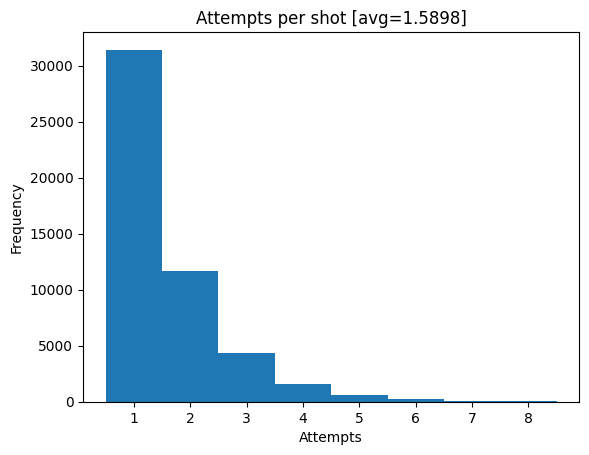

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

shots = main.emulator(n_qubits=3).with_seed(0).with_shots(50000).run()
attempts = [int(shot.as_dict()["attempts"]) for shot in shots]
avg_attempts = sum(attempts) / len(shots)

fig, ax = plt.subplots(1, 1)
ax.hist(attempts, bins=np.array(range(1, 10)) - 0.5)
ax.set_title(f"Attempts per shot [avg={avg_attempts}]")
ax.set_xlabel("Attempts")
ax.set_ylabel("Frequency")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
plt.show()

Finally, inverting the average number of shots required yields the experimental success rate for the implemented scheme. Following the Law of Large Numbers, increasing the number of shots yields a better approximation to the true success rate, which we can compare to the analytic success rate of $5/8$ provided in [arXiv:1311.1074](https://arxiv.org/abs/1311.1074).

In [4]:
def exp_with_shots(n_shots: int) -> None:
    shots = main.emulator(n_qubits=3).with_seed(0).with_shots(n_shots).run()
    attempts = [int(shot.as_dict()["attempts"]) for shot in shots]
    total_attempts = sum(attempts)
    print(f" Shots: {n_shots} ".center(50, "-"))
    print(f"Average attempts: {total_attempts / len(shots)}")
    print(f"Predicted rate: {len(shots) / total_attempts}")

print(f"Analytic rate: {5/8}")
exp_with_shots(100)
exp_with_shots(1000)
exp_with_shots(10000)

Analytic rate: 0.625
------------------- Shots: 100 -------------------
Average attempts: 1.49
Predicted rate: 0.6711409395973155
------------------ Shots: 1000 -------------------
Average attempts: 1.545
Predicted rate: 0.6472491909385113
------------------ Shots: 10000 ------------------
Average attempts: 1.5842
Predicted rate: 0.6312334301224592


## Validation

To ensure we have implemented the given Unitary correctly, we must compare it to a reference implementation. Guppy itself does not allow loading arbitrary unitary matrices, but we can utilize [`pytket`](https://docs.quantinuum.com/tket/api-docs/) to achieve this goal for the single-qubit case.

First, we express the unitary as a single matrix:

\begin{equation*}
V_3 = (I + 2iZ)/\sqrt{5} = \left(\begin{pmatrix}1&0\\0&1\end{pmatrix} + \begin{pmatrix}2i&0\\0&-2i\end{pmatrix}\right)/\sqrt{5} = \begin{pmatrix}\frac{1+2i}{\sqrt{5}}&0\\0&\frac{1-2i}{\sqrt{5}}\end{pmatrix}
\end{equation*}

We then load the matrix into `pytket` as an opaque block, add it to a circuit and let the library synthesise full circuit by telling it to decompose the block. You can find out more about how circuit generation works in `pytket` [here](https://docs.quantinuum.com/tket/user-guide/examples/circuit_construction/circuit_generation_example.html), and about how Guppy and `pytket` interact [here](https://docs.quantinuum.com/guppy/migration_guide.html).

In [5]:
from pytket.circuit import Unitary1qBox, OpType, Circuit
from pytket.passes import DecomposeBoxes, AutoRebase

unitary = np.array([[(1 + 2j) / math.sqrt(5), 0], [0, (1 - 2j) / math.sqrt(5)]])
circ = Circuit(1).add_gate(Unitary1qBox(unitary), [0])
DecomposeBoxes().apply(circ)

# Make sure Guppy can understand the gate set
rebase = AutoRebase({OpType.CX, OpType.Rz, OpType.H, OpType.CCX})
rebase.apply(circ)

unitary_func = guppy.load_pytket("unitary1q", circ, use_arrays=False)

Finally, we sample shots from both the reference unitary and the RUS implementation we created on different input states of the $X$ basis and compare. For this, we create a helper function that constructs the emulators for some configurations of initialization gates, and a second helper function that runs the experiment with a given configuration and displays a side-by-side plot comparison of the results.

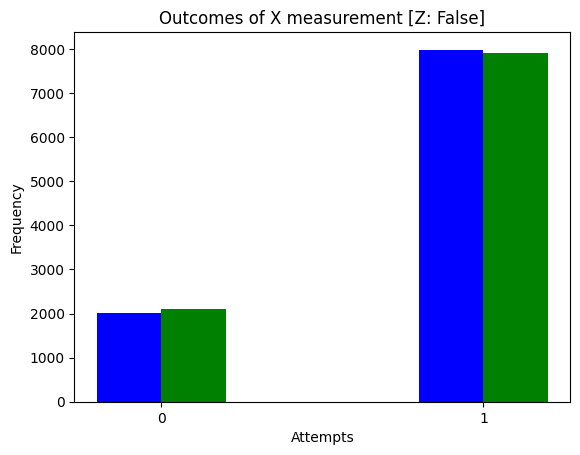

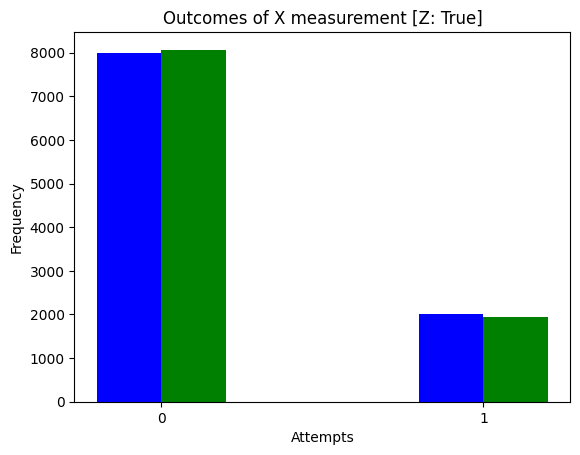

In [6]:
from guppylang.std.lang import comptime
from guppylang.std.quantum import x
from guppylang.emulator import EmulatorInstance


def compile_emulators(*, apply_z: bool) -> tuple[EmulatorInstance, EmulatorInstance]:
    @guppy
    def _rus() -> None:
        q = qubit()
        h(q)
        if comptime(apply_z):
            z(q)
        repeat_until_success(q)
        h(q)
        result("outcome", measure(q))
    _rus.check()

    @guppy
    def _ref() -> None:
        q = qubit()
        h(q)
        if comptime(apply_z):
            z(q)
        unitary_func(q)
        h(q)
        result("outcome", measure(q))
    _ref.check()

    return _rus.emulator(n_qubits=3), _ref.emulator(n_qubits=circ.n_qubits)

def run_experiment(*, apply_z: bool, n_shots: int) -> None:
    rus_emulator, ref_emulator = compile_emulators(apply_z=apply_z)

    rus_shots = rus_emulator.with_seed(0).with_shots(n_shots).run()
    rus_positive_outcomes = sum(shot.as_dict()["outcome"] for shot in rus_shots)
    
    ref_shots = ref_emulator.with_seed(0).with_shots(n_shots).run()
    ref_positive_outcomes = sum(shot.as_dict()["outcome"] for shot in ref_shots)

    _, ax = plt.subplots(1, 1)
    ax.bar([-0.1, 0.9], [n_shots - rus_positive_outcomes, rus_positive_outcomes], width=0.2, color="b")
    ax.bar([0.1, 1.1], [n_shots - ref_positive_outcomes, ref_positive_outcomes], width=0.2, color="g")
    ax.set_title(f"Outcomes of X measurement [Z: {apply_z}]")
    ax.set_xlabel("Attempts")
    ax.set_ylabel("Frequency")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    plt.show()

run_experiment(apply_z=False, n_shots=10000)
run_experiment(apply_z=True, n_shots=10000)